# Plot bathymetry at selected station location 

#### Input files
1. Global topography from Smith & Sandwell (1997), 1 min resolution. You can find it here: https://topex.ucsd.edu/marine_topo/ in the section "Global Topography": https://topex.ucsd.edu/pub/global_topo_1min/ At the same link, you can also find other bathymetric products at higher resolution. 
2. Track file. This is a csv file which includes station number, longitude, latitude, and station depth. This file is needed for many cruise code, and usually will have ports indicate with station number 0

#### What does the code do?
The code reads in the topography file and the track file. The user will select the station number of interest. The code will then find that location in the global bathymetry file and plot the bathymetry contours at the selected station within a ~6nm radius. It will also add a 0.5nm radius circle, which is more or less the distance that the ship will drift while on station (this is inevitable to make sure that the winch cable remains straight; depending on the condition, the drift could be a bit more). The User can change the radius and resolution of the bathymetry.

Why you might need this code? This code is useful to check for bathymetric slope before a cast. This can be used to inform the bridge (if needed) on which preferential direction to drift, i.e. you would want to drift downgradient and not upgradient (into the slope!). Note that the drifting direction ultimately will also depend on the current and wind velocity & directions. This plot would at least help you make an informed decision, for example on whether to stop at 15 m from the bottom or whether to ask the winch to come up "as fast as they can", which is usually 75 mpm (rather than the standard 60 mpm).

#### For future cruises 
Simply input a new track file and change paths to input files - then you should be ready to go!

Code by L.Cimoli, April 2023
For questions, email lc929@cam.ac.uk

In [25]:
# Import libraries
import os
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Set user variables
station_we_are_at = 150  # where we are (station number)

# Lat/Lon limits for a radius around the station. Change the +- values to have a smaller or larger radius
# 1nm = 0.0167 dec, 2nm = 0.033 dec, 5nm = 0.0833 dec, 6nm ~ 0.1 dec
d_latlon = 0.1  # Plot size
ship_rad = 0.0167  # Ship radius

# Script parameters
print_info = True  # Print info from data files?
download_data = True  # Download data?
high_res = False  # Use high-resolution topology file? NB This is large and take a long time to download/read

# Data file and cruise parameters
trk_filepath = "resources/"  # Path to where track files are stored
trk_name = "a16n_2023_track_leg2.csv"  # Track file to use

topo_filepath = "resources/"  # Path to where topology files are stored
if high_res:
    topo_name = "SRTM15_v2.5.nc"  # High-res topology file to use
else:
    topo_name = "topo_25.1.nc"  # Low-res topology file to use

# Select path where you want to save the outputs, the cruise name and some figure settings
path2outputs = ""
paramfig = {"dpi": 300, "outformat": "png", "do_saving": False}

In [27]:
# Import TRACK INFO
trk = pd.read_csv(f"{trk_filepath}{trk_name}")
trk = trk[trk.depth != 0]  # Remove ports
trk = trk.set_index("station")  # Change index to station number

if print_info:
    print("Possible stations:")
    print(trk)

Possible stations:
         longitude   latitude  depth
station                             
76       -24.50000  28.000000   5217
77       -24.21875  28.500000   5201
78       -23.93750  29.000000   5189
79       -23.65625  29.500000   5242
80       -23.37500  30.000000   5242
...            ...        ...    ...
146      -20.00000  62.333333   1799
147      -20.00000  62.750000   1412
148      -20.00000  63.125000   1005
149      -20.00000  63.214000    554
150      -20.00000  63.300000    264

[75 rows x 3 columns]


In [28]:
# Latmin/latmax and lonmin/lonmax are used to select the area with ~6nm-radius around the station location
station_lat = trk.loc[station_we_are_at]["latitude"]
station_lon = trk.loc[station_we_are_at]["longitude"]
latmin = station_lat - d_latlon
latmax = station_lat + d_latlon
# longitude is -ve
lonmin = station_lon + d_latlon
lonmax = station_lon - d_latlon

In [29]:
# Download TOPOGRAPHY DATA if needed
if (not os.path.exists(topo_filepath+topo_name)):
    print("Cannot locate topography file.")

    if download_data:
        if high_res:
            topo_url = (
                f"https://topex.ucsd.edu/pub/srtm15_plus/{topo_name}"
            )
        else:
            topo_url = (
                f"https://topex.ucsd.edu/pub/global_topo_1min/{topo_name}"
            )
        print(f"Attempting to download from online source: {topo_url}")

        from tqdm import tqdm
        import urllib.request
        import urllib.error

        # Create a progress bar
        class TqdmUpTo(tqdm):
            """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
            def update_to(self, b=1, bsize=1, tsize=None):
                """
                b  : int, optional
                    Number of blocks transferred so far [default: 1].
                bsize  : int, optional
                    Size of each block (in tqdm units) [default: 1].
                tsize  : int, optional
                    Total size (in tqdm units). If [default: None] remains unchanged.
                """
                if tsize is not None:
                    self.total = tsize
                return self.update(b * bsize - self.n)  # also sets self.n = b * bsize
        

        
        try:
            with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                      desc=topo_url.split('/')[-1]) as t:  # all optional kwargs
                urllib.request.urlretrieve(topo_url, filename=topo_filepath+topo_name,
                               reporthook=t.update_to, data=None)
                t.total = t.n
        except urllib.error.URLError as e:
            print("Cannot download topology file.")
            print(e)
else:
    print(f"Reading topology from {topo_name}")

Reading topology from topo_25.1.nc


In [30]:
# Import TOPOGRAPHY FILE
topo_data = netCDF4.Dataset(f"{topo_filepath}{topo_name}")
# Extract bathymetry values within selected area
lat, lon, topo = topo_data.variables["lat"], topo_data.variables["lon"], topo_data.variables["z"]
latvals = lat[:]
lonvals = lon[:]
topovals = topo[:]

In [31]:
# Values local to station
latlims = latvals[(latvals >= latmin) & (latvals <= latmax)]
lonlims = lonvals[(lonvals <= lonmin) & (lonvals >= lonmax)]

# Get topography in this box
topogr = topovals[(latvals >= latmin) & (latvals <= latmax), :]
topogr = topogr[:, (lonvals <= lonmin) & (lonvals >= lonmax)]

if print_info:
    print(f"Topography section is size {topogr.shape}")
    print(f"Max. depth = {topogr.max()}")
    print(f"Min. depth = {topogr.min()}")

Topography section is size (12, 12)
Max. depth = -94.83255004882812
Min. depth = -749.0122680664062


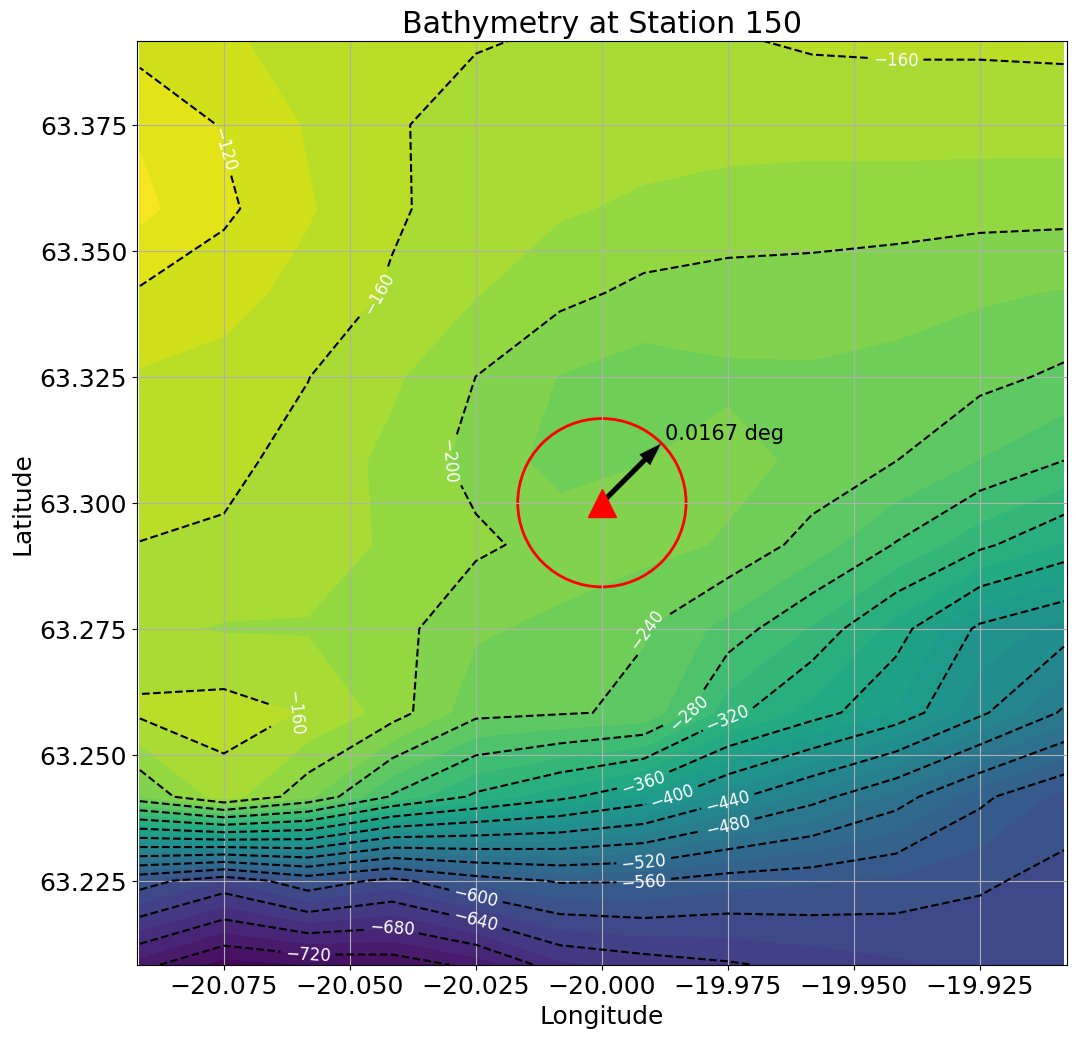

In [32]:
# Plot topography around station

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
plt.rcParams.update({"font.size": 18})

plt.contourf(lonlims, latlims, topogr, 32)
cs = plt.contour(lonlims, latlims, topogr, 16, colors="black")
plt.clabel(cs, colors="w", inline=True, fontsize=12)

plt.plot(
    station_lon,
    station_lat,
    "r^",
    ms=20,
)

circle1 = plt.Circle(
    (station_lon, station_lat),
    ship_rad,
    color="r",
    fill=False,
    lw=2,
)
ax.add_patch(circle1)
label = ax.annotate(f"{ship_rad} deg", xy=(station_lon+0.75*ship_rad, station_lat+0.75*ship_rad), fontsize=15, ha="left", color="k")
plt.arrow(station_lon, station_lat, 0.7*ship_rad, 0.7*ship_rad, color="k", ls="--", linewidth=0.1, length_includes_head=True,)

plt.grid()
# plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Bathymetry at Station {station_we_are_at}")
plt.axis("equal")

if paramfig["do_saving"]:
    plt.savefig(
        fname=f"{path2outputs}{trk_name}_topography_station_{station_we_are_at}.{paramfig['outformat']}",
        dpi=paramfig["dpi"],
    )